# Product Design Mining - as a Product Designer, I want to know users' preferences - specifically paint points - , so that I can improve the product

### False positives are more costly, in that they miss critical negative pain points and feedback by seeing them as positive - this informs metric of F 0.5 on Positive class of sentiment being the focus

### False negatives on Negative class are the focus as they miss out on actual negative feedbacks, informing a metric of F2 on Negative class of sentiment

## Business value: Allows for improving the product and bring in new customers/remedy possible churn of customers from the platform or brand loyalty

# Imports and reading in data

In [1]:
import keras
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import yellowbrick
import tensorflow as tf
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nlp = spacy.load('en_core_web_sm')

# Import the displaCy library
from spacy import displacy

Using TensorFlow backend.
/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from sklearn import metrics
import missingno as msno
import plotly.express as px

In [3]:
plt.style.use('seaborn-talk')

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

## Reading in data

In [5]:
# df = pd.read_csv('drive/My Drive/judge-1377884607_tweet_product_company.csv',encoding = "ISO-8859-1")
df = pd.read_csv('judge-1377884607_tweet_product_company.csv',encoding = "ISO-8859-1")

df.head(20)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [6]:
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

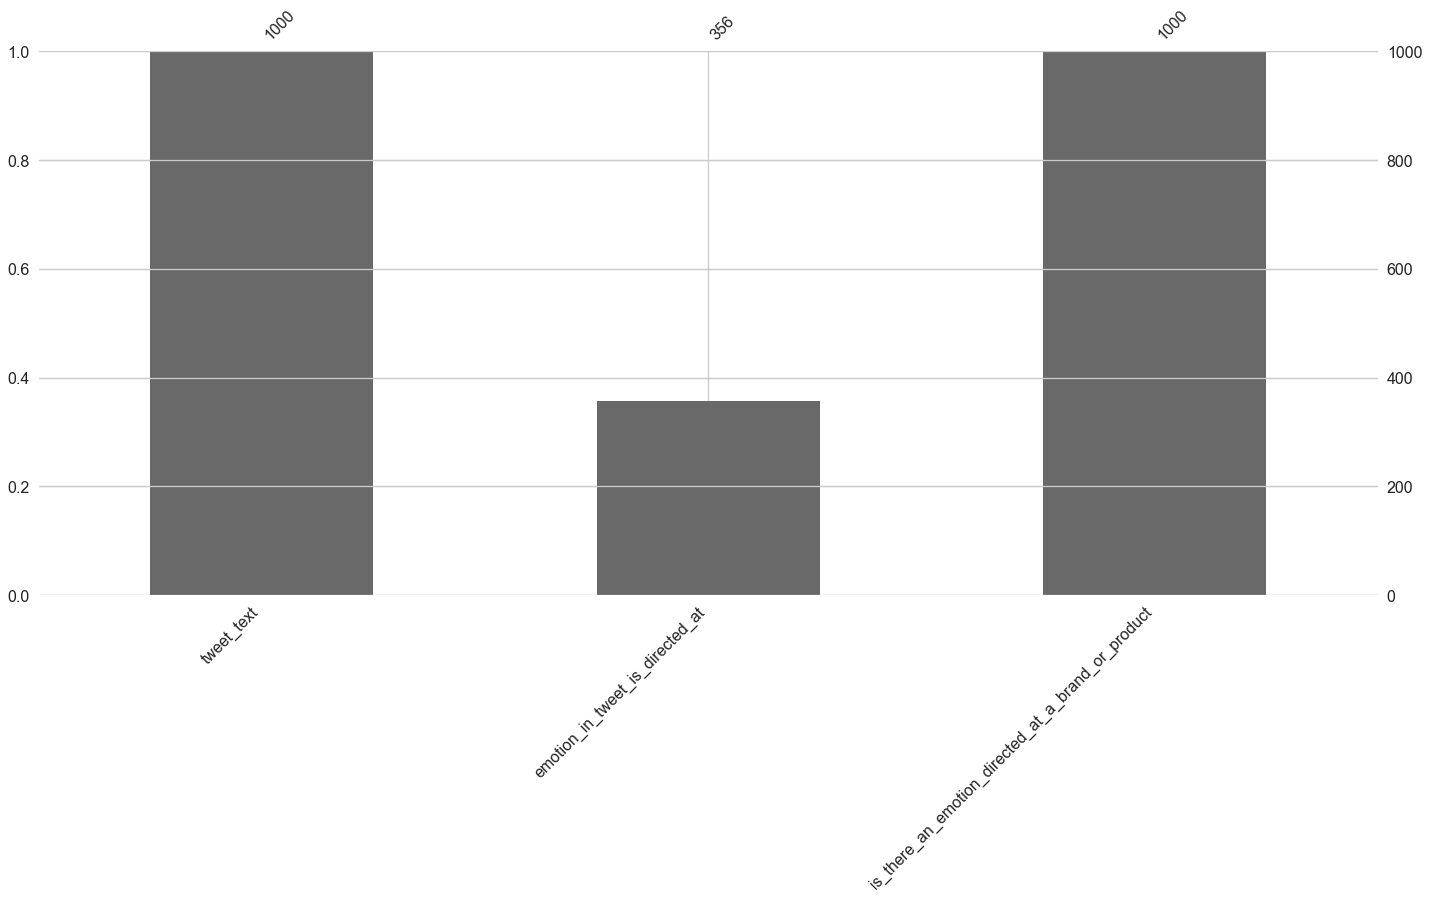

In [7]:
msno.bar(df.sample(1000))

In [8]:
df.dropna(subset=['tweet_text'],inplace=True)

df.isnull().sum()

tweet_text                                               0
emotion_in_tweet_is_directed_at                       5801
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [9]:
df.emotion_in_tweet_is_directed_at.value_counts(dropna=False)

NaN                                5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [10]:
print(5801 / len(df))

0.6380334359876815


In [11]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(dropna=False)

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [12]:
df.fillna('unknown', inplace=True) 

df.isnull().sum()

tweet_text                                            0
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

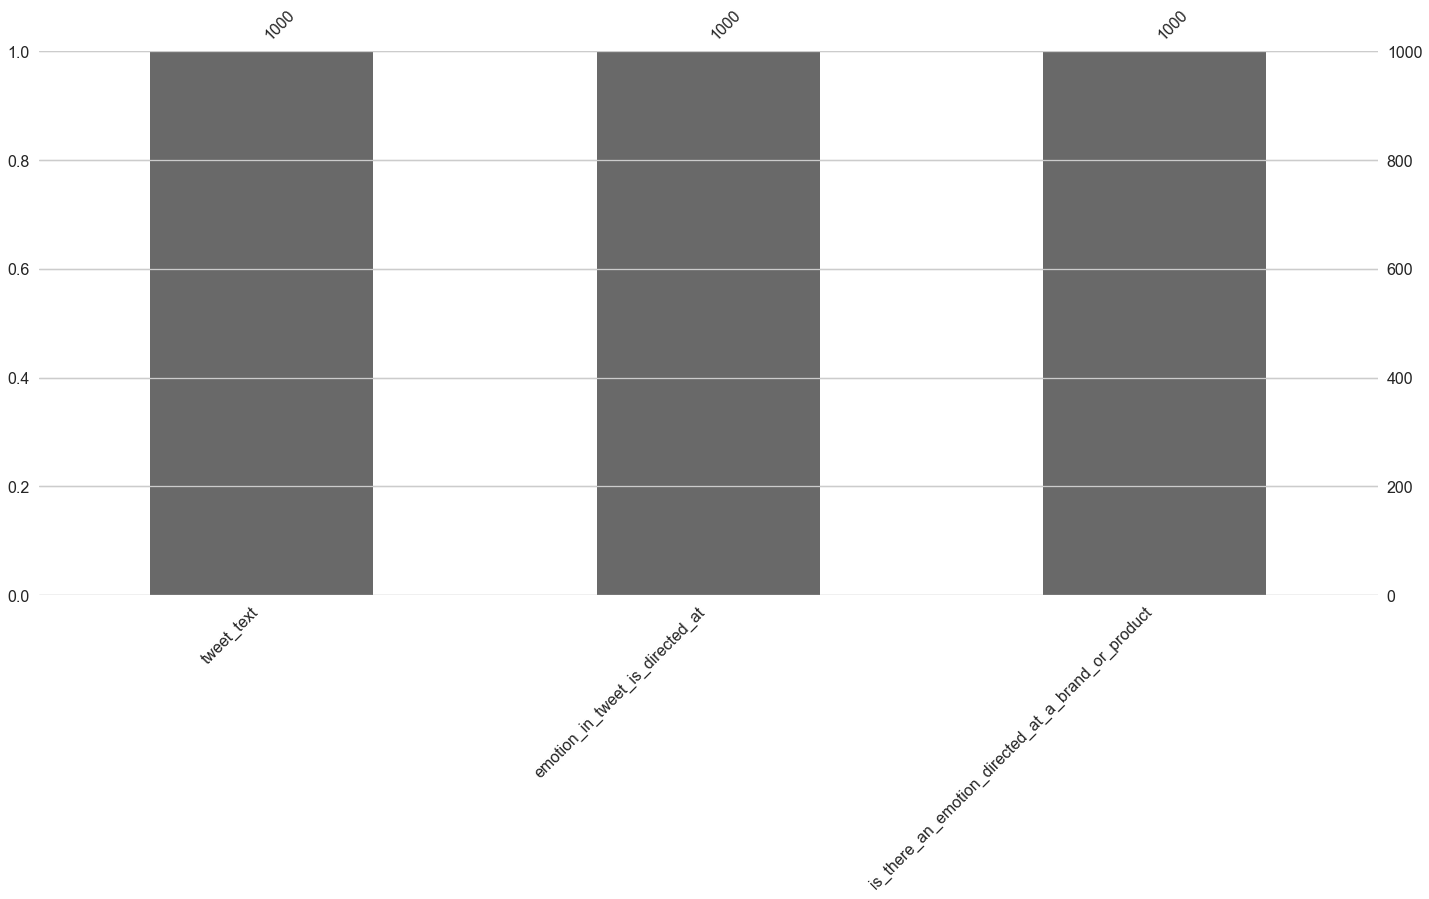

In [13]:
msno.bar(df.sample(1000))

In [14]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(dropna=False)

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

# Preprocessing

## Renaming columns

In [15]:
df = df.rename(columns={"tweet_text": "text", "emotion_in_tweet_is_directed_at":"direction", "is_there_an_emotion_directed_at_a_brand_or_product":"sentiment"})

df

,text,direction,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",unknown,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",unknown,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,unknown,No emotion toward brand or product


In [16]:
df.sentiment.value_counts(dropna=False)

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [17]:
df.direction.value_counts(dropna=False)

unknown                            5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: direction, dtype: int64

## Mapping sentiment to 0 for negative, 1 for neutral-like, 2 for positive

In [18]:
df.sentiment = df.sentiment.map({'Positive emotion': 2, 'No emotion toward brand or product':1, "I can't tell":1, 'Negative emotion': 0})

In [19]:
df.sentiment.value_counts(dropna=False)

1    5544
2    2978
0     570
Name: sentiment, dtype: int64

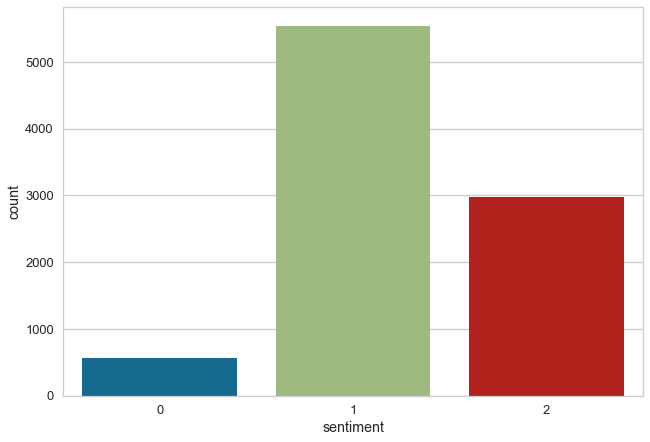

In [20]:
sns.countplot(df.sentiment)

In [21]:
df.direction.value_counts(dropna=False)

unknown                            5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: direction, dtype: int64

## Mapping direction of the tweet to 0 for apple and its products/services, 1 for google, 2 for unknown

In [22]:
df.direction = df.direction.map({'iPad':0, 'Apple':0,'iPad or iPhone App':0,'iPhone':0,'Other Apple product or service':0,'Google':1,'Other Google product or service':1,'Android App':1,'Android':1, 'unknown':2})

In [23]:
df.direction.value_counts(dropna=False)

2    5801
0    2409
1     882
Name: direction, dtype: int64

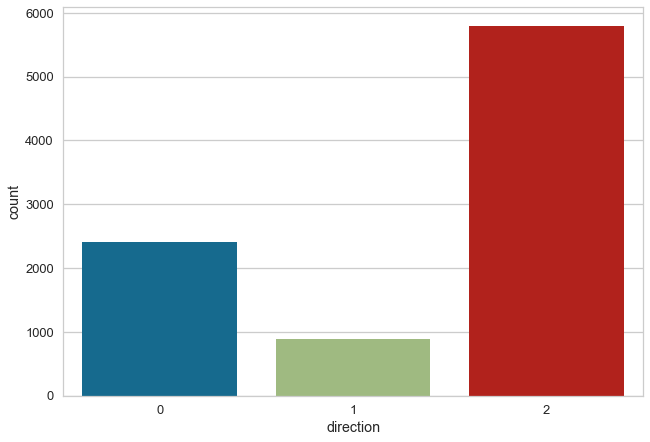

In [24]:
sns.countplot(df.direction)

In [25]:
#Wherein 1 in sentiment is not having a strong emotion/can't tell, and 2 in direction is a NaN that's been filled 
neutrals = [1,2]
df[(df[['sentiment','direction']].values == neutrals).all(axis=1)]

,text,direction,sentiment
5,@teachntech00 New iPad Apps For #SpeechTherapy...,2,1
16,Holler Gram for iPad on the iTunes App Store -...,2,1
32,"Attn: All #SXSW frineds, @mention Register fo...",2,1
33,Anyone at #sxsw want to sell their old iPad?,2,1
34,Anyone at #SXSW who bought the new iPad want ...,2,1
...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",2,1
9089,"Wave, buzz... RT @mention We interrupt your re...",2,1
9090,"Google's Zeiger, a physician never reported po...",2,1
9091,Some Verizon iPhone customers complained their...,2,1


In [26]:
len(df)

9092

In [27]:
df.sentiment.value_counts(dropna=False)

1    5544
2    2978
0     570
Name: sentiment, dtype: int64

In [28]:
df.direction.value_counts(dropna=False)

2    5801
0    2409
1     882
Name: direction, dtype: int64

In [29]:
df.query('@neutrals[0] != sentiment and @neutrals[1] == direction').shape[0]

357

## Shows that the NaNs of direction were entered as a neutral sentiment

In [30]:
5801 - 357

5444

# General text preprocessing function

In [31]:
def preprocess(text):
    text = text.str.replace("(<br/>)", "")
    text = text.str.replace('(<a).*(>).*(</a>)', '')
    text = text.str.replace('(&amp)', '')
    text = text.str.replace('(&gt)', '')
    text = text.str.replace('(&lt)', '')
    text = text.str.replace('(\xa0)', ' ')  
    text = text.str.replace(',','')
    text = text.str.replace('{', '')
    text = text.str.replace('}', '')
    text = text.str.replace('.', '')
    text = text.str.replace(':', '')
    text = text.str.replace('-', '')
    return text

clean_df = df 
clean_df['text'] = preprocess(clean_df['text'])

clean_df['text']

0       @wesley83 I have a 3G iPhone After 3 hrs tweet...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also They...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW Marissa Ma...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt your regula...
9090    Google's Zeiger a physician never reported pot...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

# Creating new features
Creating features out of the length of a tweet, words in a tweet, and amounts of hashtags, capital words, and exclamation/question marks

In [32]:
def tweet_special_count(string, character):
    '''docstring'''
    w = string.split()
    
    char = [word for word in w if word.startswith(character)]
    
    return len(char)

In [33]:
clean_df['tweet_len'] = clean_df['text'].astype(str).apply(len)
clean_df['tweet_words'] = clean_df['text'].apply(lambda x: len(str(x).split()))
clean_df['hash_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '#'))
clean_df['mention_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '@'))
clean_df['capital_words'] = clean_df['text'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)))
clean_df['excl_q_marks'] = clean_df['text'].apply(lambda x: len(re.findall(r'!|\?', x)))
clean_df.head()



,text,direction,sentiment,tweet_len,tweet_words,hash_cnt,mention_cnt,capital_words,excl_q_marks
0,@wesley83 I have a 3G iPhone After 3 hrs tweet...,0,0,122,23,2,1,1,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,0,2,137,22,1,2,1,1
2,@swonderlin Can not wait for #iPad 2 also They...,0,2,77,15,2,1,1,0
3,@sxsw I hope this year's festival isn't as cra...,0,0,81,15,1,1,0,0
4,@sxtxstate great stuff on Fri #SXSW Marissa Ma...,1,2,125,17,1,1,1,0


In [34]:
clean_df.columns

Index(['text', 'direction', 'sentiment', 'tweet_len', 'tweet_words',
       'hash_cnt', 'mention_cnt', 'capital_words', 'excl_q_marks'],
      dtype='object')

# Summary stats and visuals

## Top tokens - items and products with named entity recognition

In [35]:
from collections import Counter
tokens = nlp(''.join(str(df.text.tolist())))
items = [x.text for x in tokens.ents]
Counter(items).most_common(20)

[('Apple', 1122),
 ('iPhone', 843),
 ('Google', 775),
 ('SXSW', 750),
 ('Austin', 642),
 ('2', 490),
 ('today', 301),
 ('#sxsw #', 266),
 ('Today', 235),
 ('#sxsw', 234),
 ('Android', 232),
 ('#SXSW #', 232),
 ('sxsw', 152),
 ('Launch Major New Social Network', 152),
 ('Circles', 142),
 ('RT @mention', 138),
 ('SxSW', 107),
 ('iPad2', 95),
 ('RT @mention Google', 94),
 ("'RT @mention", 94)]

### Most Common Tokens W/Entities

In [39]:
item_cnt = Counter(items).most_common(20)
df_items = pd.DataFrame(item_cnt, columns =['text', 'count'])


fig = px.bar(df_items, y="text", x="count", orientation='h',title="Most Common Tokens W/ Entities Mentioned")
fig.show()

# df_items.plot.barh(x='text', y='count', title="Most Common Tokens W/ Entities Mentioned").invert_yaxis()

### Most Common Products

In [40]:
products = []
for ent in tokens.ents:
    if ent.label_ == 'PRODUCT':
        products.append(ent.text)
        
prdct_cnt = Counter(products).most_common(20)
df_prod = pd.DataFrame(prdct_cnt, columns =['text', 'count'])

fig = px.bar(df_prod, y="text", x="count", orientation='h',title="Most Common Products Mentioned")
fig.show()

# df_prod.plot.barh(x='text', y='count', title="Most Common Products Mentioned").invert_yaxis()

## Analysis of numerical features
### Distributions

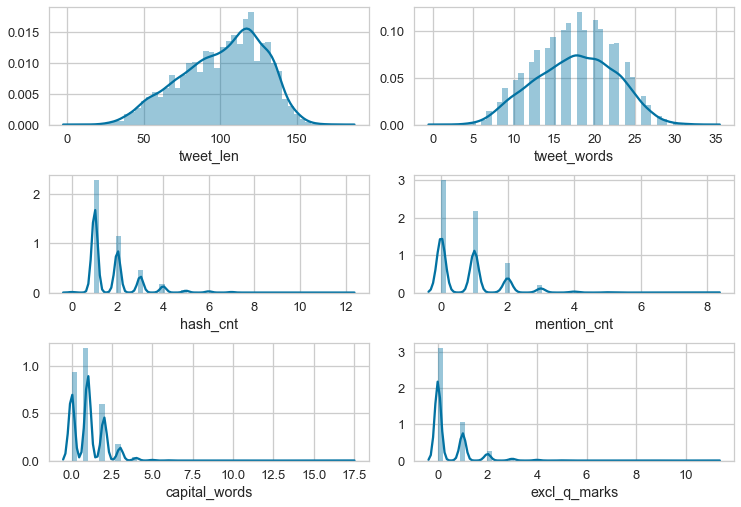

In [48]:
fig, axs = plt.subplots(ncols=2, nrows=3)
sns.distplot(clean_df['tweet_len'], ax=axs[0][0])
sns.distplot(clean_df['tweet_words'], ax=axs[0][1])
sns.distplot(clean_df['hash_cnt'], ax=axs[1][0])
sns.distplot(clean_df['mention_cnt'], ax=axs[1][1])
sns.distplot(clean_df['capital_words'], ax=axs[2][0])
sns.distplot(clean_df['excl_q_marks'], ax=axs[2][1])
plt.tight_layout()

### Correlation matrix - looks like not much correlation/colinearity

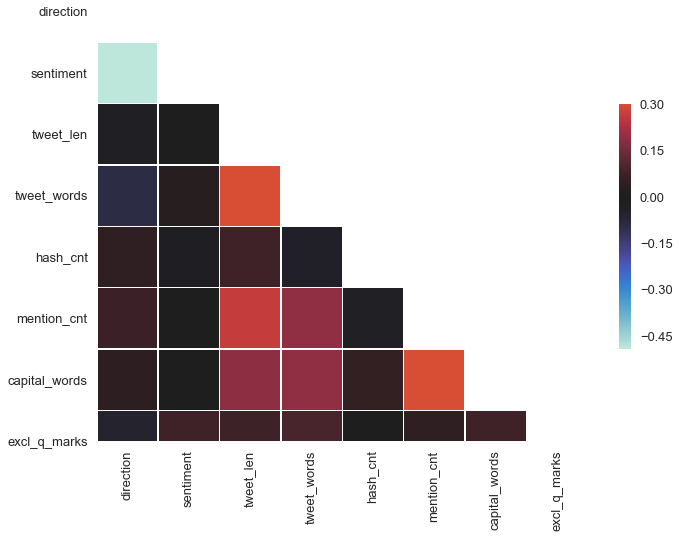

In [49]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Pairplot

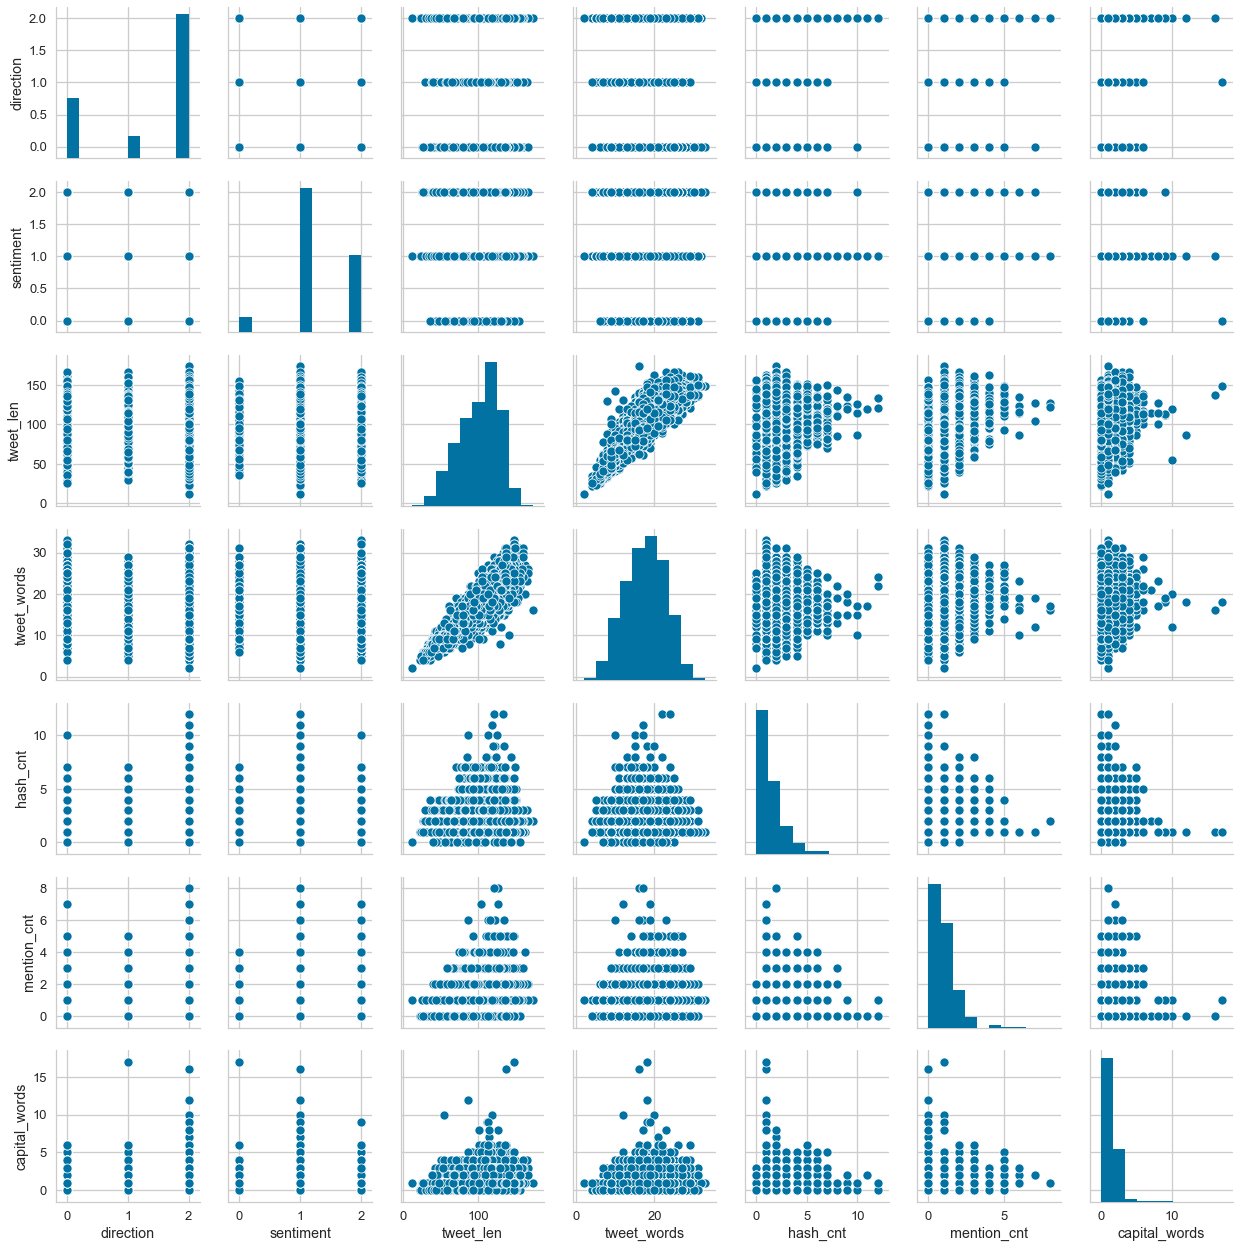

In [51]:
sns.pairplot(clean_df[['direction', 'sentiment', 'tweet_len','tweet_words',
       'hash_cnt', 'mention_cnt', 'capital_words']])

#### Dropping tweet_len due to high correlation with tweet_words

In [52]:
clean_df = clean_df.drop('tweet_len',axis=1)

clean_df.head()

,text,direction,sentiment,tweet_words,hash_cnt,mention_cnt,capital_words,excl_q_marks
0,@wesley83 I have a 3G iPhone After 3 hrs tweet...,0,0,23,2,1,1,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,0,2,22,1,2,1,1
2,@swonderlin Can not wait for #iPad 2 also They...,0,2,15,2,1,1,0
3,@sxsw I hope this year's festival isn't as cra...,0,0,15,1,1,0,0
4,@sxtxstate great stuff on Fri #SXSW Marissa Ma...,1,2,17,1,1,1,0


# Further preprocessing - tokenizing and lemmatizing, stopword removal

In [53]:
clean_df['text']

0       @wesley83 I have a 3G iPhone After 3 hrs tweet...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also They...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW Marissa Ma...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt your regula...
9090    Google's Zeiger a physician never reported pot...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

In [54]:
from wordcloud import WordCloud

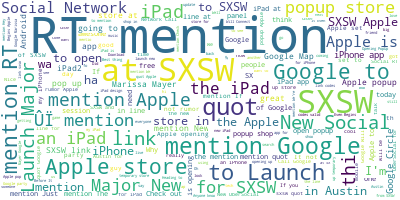

In [60]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(clean_df['text'].to_string())

wordcloud.to_image()

In [61]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def stem_sentences(sentence):
    tokens = sentence.split()
    lemma_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemma_tokens)

clean_df['text'] = clean_df['text'].apply(stem_sentences)

clean_df['text']

0       @wesley83 I have a 3G iPhone After 3 hr tweeti...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also They...
3       @sxsw I hope this year's festival isn't a cras...
4       @sxtxstate great stuff on Fri #SXSW Marissa Ma...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt your regula...
9090    Google's Zeiger a physician never reported pot...
9091    Some Verizon iPhone customer complained their ...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

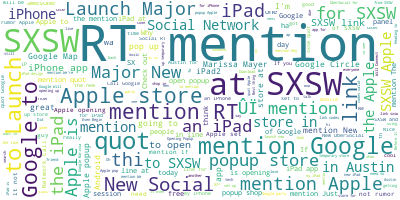

In [62]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(clean_df['text'].to_string())

wordcloud.to_image()

In [63]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelburak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
clean_df['text'] = clean_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_list)]))

clean_df['text']

0       @wesley83 I 3G iPhone After 3 hr tweeting #RIS...
1       @jessedee Know @fludapp ? Awesome iPad/iPhone ...
2       @swonderlin Can wait #iPad 2 also They sale #SXSW
3       @sxsw I hope year's festival crashy year's iPh...
4       @sxtxstate great stuff Fri #SXSW Marissa Mayer...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt regularly s...
9090    Google's Zeiger physician never reported poten...
9091    Some Verizon iPhone customer complained time f...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

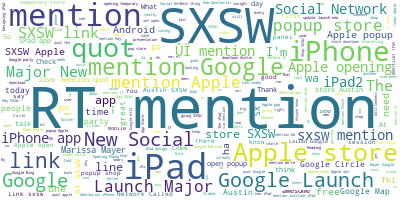

In [65]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(clean_df['text'].to_string())

wordcloud.to_image()

In [66]:
clean_df['tweet_words'] = clean_df['text'].apply(lambda x: len(str(x).split()))
clean_df['hash_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '#'))
clean_df['mention_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '@'))
clean_df['capital_words'] = clean_df['text'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)))
clean_df['excl_q_marks'] = clean_df['text'].apply(lambda x: len(re.findall(r'!|\?', x)))
clean_df.head()

,text,direction,sentiment,tweet_words,hash_cnt,mention_cnt,capital_words,excl_q_marks
0,@wesley83 I 3G iPhone After 3 hr tweeting #RIS...,0,0,17,2,1,1,1
1,@jessedee Know @fludapp ? Awesome iPad/iPhone ...,0,2,16,1,2,1,1
2,@swonderlin Can wait #iPad 2 also They sale #SXSW,0,2,9,2,1,1,0
3,@sxsw I hope year's festival crashy year's iPh...,0,0,10,1,1,0,0
4,@sxtxstate great stuff Fri #SXSW Marissa Mayer...,1,2,16,1,1,1,0


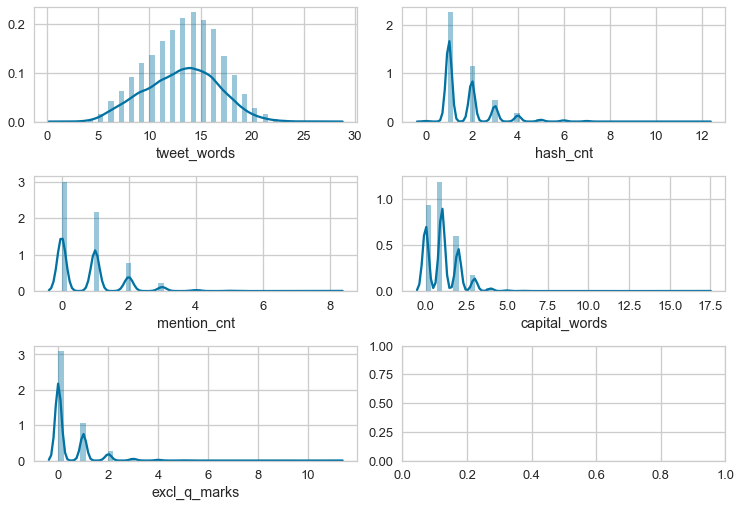

In [67]:
fig, axs = plt.subplots(ncols=2, nrows=3)
sns.distplot(clean_df['tweet_words'], ax=axs[0][0])
sns.distplot(clean_df['hash_cnt'], ax=axs[0][1])
sns.distplot(clean_df['mention_cnt'], ax=axs[1][0])
sns.distplot(clean_df['capital_words'], ax=axs[1][1])
sns.distplot(clean_df['excl_q_marks'], ax=axs[2][0])
plt.tight_layout()

In [68]:
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()
clean_df['tokens'] = clean_df['text'].apply(tt.tokenize)

# Visuals, continued

## t-SNE of k-means clusters, overall document, text vs. classes

/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning:

No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.

/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning:

No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning



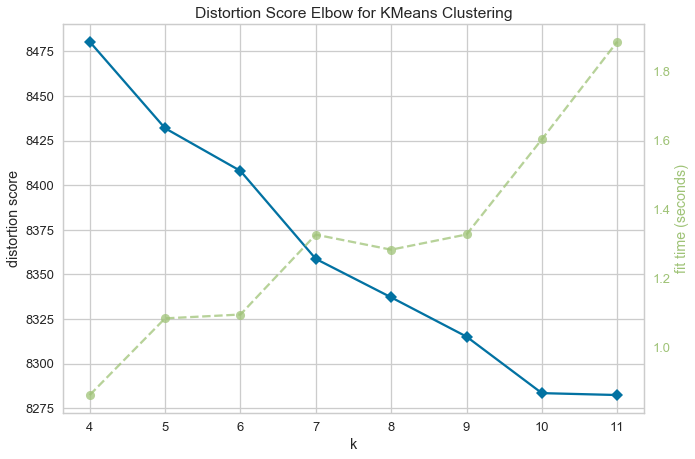

In [69]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

tfidf = TfidfVectorizer()

X = tfidf.fit_transform(clean_df['text'])

tf_words = tfidf.get_feature_names()

model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X)
visualizer.show() 

### t-SNE of K-means

In [70]:
from yellowbrick.text import TSNEVisualizer
X = tfidf.fit_transform(clean_df['text'])


In [71]:
clusters = KMeans(n_clusters=6)
clusters.fit(X)


KMeans(n_clusters=6)

W0624 11:29:45.402062 4451524032 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0624 11:29:45.431298 4451524032 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0624 11:29:45.453345 4451524032 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0624 1

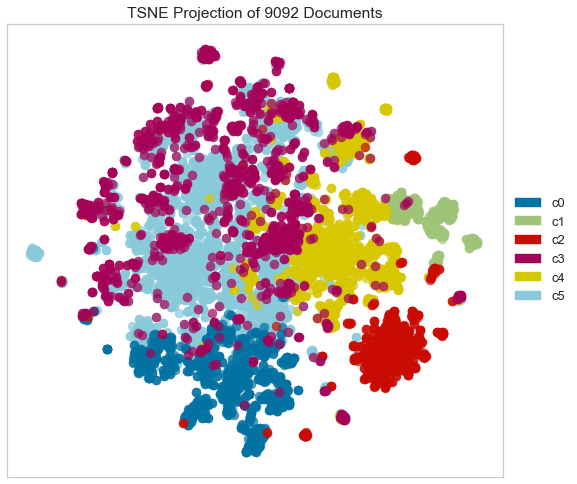

0 : apple, store, popup, austin, link, sxsw, mention, temporary, opening, ipad2
1 : network, social, circles, called, launch, major, new, today, possibly, google
2 : quot, mention, sxsw, google, rt, ipad, apple, heard, link, go
3 : mention, rt, link, sxsw, iphone, app, ipad, free, android, new
4 : google, sxsw, mention, link, circles, mayer, rt, mobile, party, marissa
5 : ipad, sxsw, iphone, link, mention, apple, app, android, rt, the


In [72]:
tsne = TSNEVisualizer(size=(800, 600))
tsne.fit(X, ["c{}".format(c) for c in clusters.labels_])

tsne.show()
common_words = clusters.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(tf_words[word] for word in centroid))
    


### TSNE of tweet text

W0624 11:30:15.567400 4451524032 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


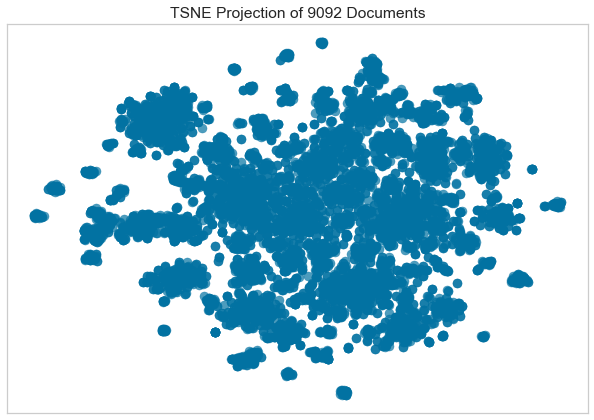

In [73]:
tsne = TSNEVisualizer()
tsne.fit(X)
tsne.show()

### TSNE of tweet text and sentiment

W0624 11:30:45.332826 4451524032 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0624 11:30:45.372656 4451524032 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0624 11:30:45.444672 4451524032 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


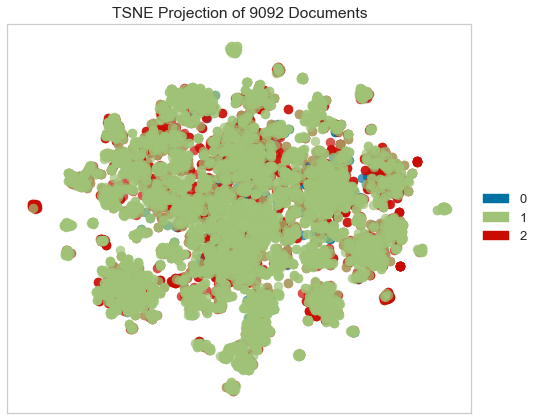

In [74]:
y = clean_df['sentiment']
tsne = TSNEVisualizer()
tsne.fit(X,y)
tsne.show()

### Word modeling t-SNE

In [75]:
from gensim.models import word2vec
from sklearn.manifold import TSNE

In [76]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['text']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(clean_df)        
corpus[0:2]

[['@wesley83',
  'I',
  '3G',
  'iPhone',
  'After',
  '3',
  'hr',
  'tweeting',
  '#RISE_Austin',
  'wa',
  'dead!',
  'I',
  'need',
  'upgrade',
  'Plugin',
  'station',
  '#SXSW'],
 ['@jessedee',
  'Know',
  '@fludapp',
  '?',
  'Awesome',
  'iPad/iPhone',
  'app',
  'likely',
  'appreciate',
  'design',
  'Also',
  "they're",
  'giving',
  'free',
  'Ts',
  '#SXSW']]

In [77]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)
model.wv['google']

array([-0.07584694, -0.02472803, -0.10198475, -0.1121625 , -0.21394622,
        0.01048075,  0.08517077, -0.0465414 , -0.02817388, -0.04382168,
       -0.01620936,  0.17832378, -0.09515362, -0.01437302,  0.21977927,
       -0.02217878,  0.01774165,  0.03779712,  0.15642518,  0.10000593,
        0.12304405, -0.28685415,  0.01675077, -0.01620447, -0.08638895,
       -0.19354795, -0.01297501, -0.1474109 , -0.15633641, -0.08175768,
        0.10387146,  0.10322649, -0.15437742, -0.0326075 ,  0.07783324,
        0.15694861,  0.21735312,  0.19194625, -0.10661642, -0.03663364,
        0.02833876,  0.05375368, -0.00403992, -0.03113271,  0.10535064,
       -0.19181167,  0.00871552,  0.08779977,  0.00640543, -0.04086478,
        0.02692832, -0.28732646,  0.04348724, -0.06206676,  0.23683074,
        0.23118259,  0.25422323, -0.15940951,  0.17228255, -0.26589262,
       -0.00218964,  0.01211475,  0.1344288 ,  0.01361752, -0.10822125,
       -0.05219582,  0.13053894,  0.11717412, -0.25521776,  0.16

/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



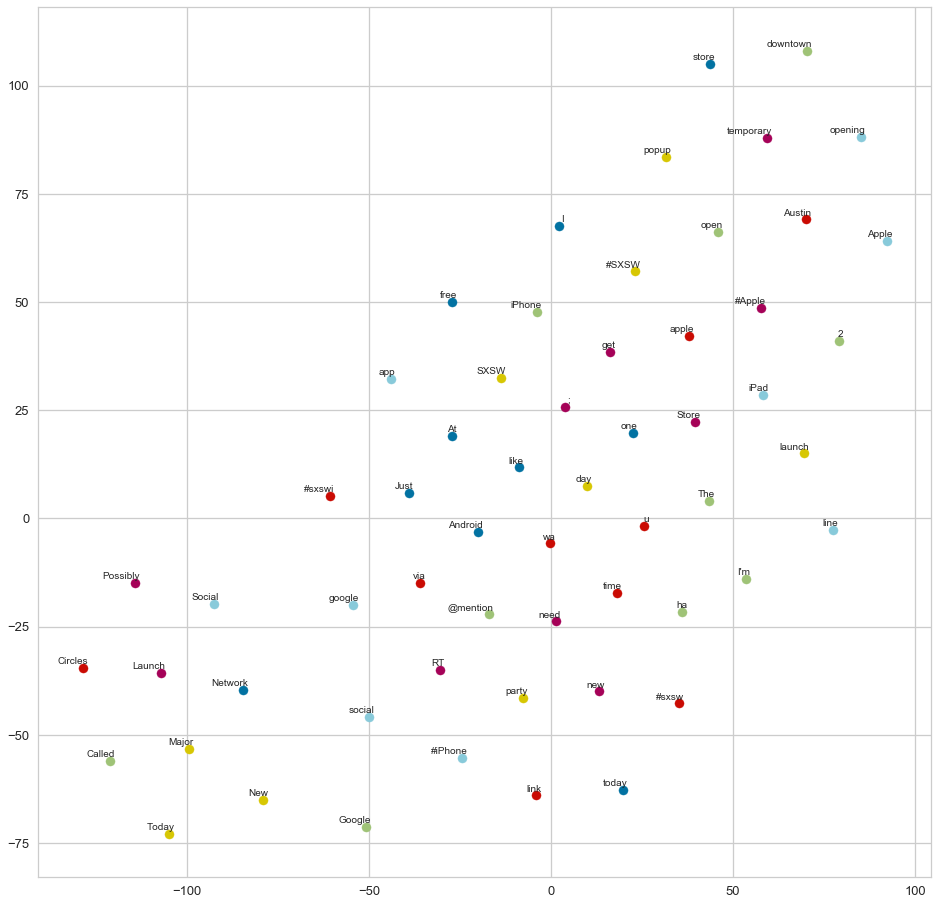

In [78]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
tsne_plot(model)

# Word2Vec Similarities and plots

In [79]:
google_similar = model.most_similar('google')

google_similar

/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('party', 0.9979071617126465),
 ('@mention', 0.9976061582565308),
 ('RT', 0.9968281984329224),
 ('#iPhone', 0.9965339303016663),
 ('new', 0.9959482550621033),
 ('#sxsw', 0.9951233863830566),
 ('At', 0.9933942556381226),
 ('Android', 0.9930580854415894),
 ('#sxswi', 0.9924656748771667),
 ('via', 0.9910758137702942)]

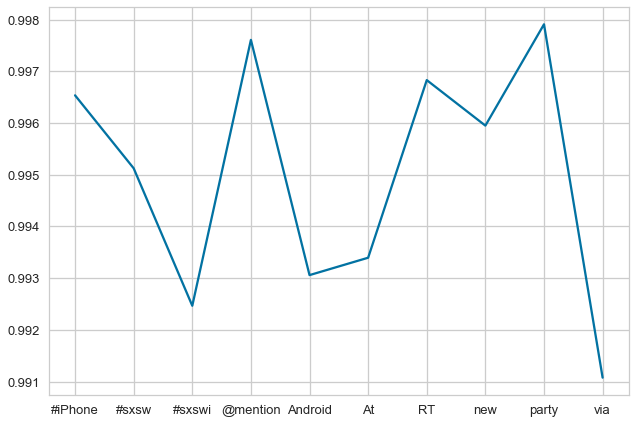

In [80]:
sns.lineplot(*zip(*google_similar))

In [81]:
apple_similar = model.most_similar('Apple')

/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



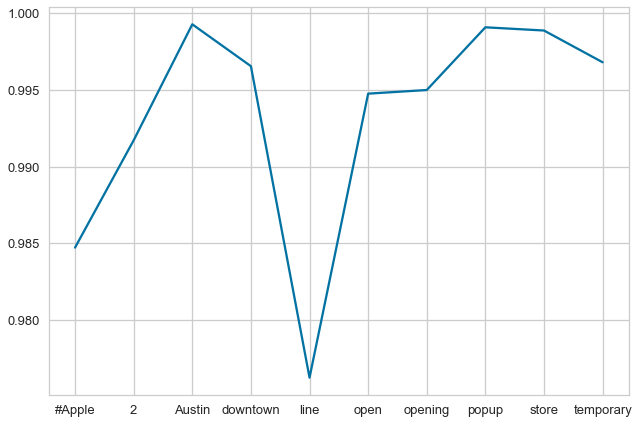

In [82]:
sns.lineplot(*zip(*apple_similar))

# Bigrams and N-grams

In [83]:
from nltk import bigrams

In [84]:
clean_df['tokens']

0       [@wesley83, I, 3G, iPhone, After, 3, hr, tweet...
1       [@jessedee, Know, @fludapp, ?, Awesome, iPad, ...
2       [@swonderlin, Can, wait, #iPad, 2, also, They,...
3       [@sxsw, I, hope, year's, festival, crashy, yea...
4       [@sxtxstate, great, stuff, Fri, #SXSW, Marissa...
                              ...                        
9088                      [Ipad, everywhere, #SXSW, link]
9089    [Wave, buzz, RT, @mention, We, interrupt, regu...
9090    [Google's, Zeiger, physician, never, reported,...
9091    [Some, Verizon, iPhone, customer, complained, ...
9092    [, Ï, ¡, , Ïà, , ü_, , , Ê, , , Î, , ...
Name: tokens, Length: 9092, dtype: object

In [85]:
#create bigrams
bigram_list = [list(bigrams(tweet)) for tweet in clean_df['tokens']]

bigram_list[:11]

[[('@wesley83', 'I'),
  ('I', '3G'),
  ('3G', 'iPhone'),
  ('iPhone', 'After'),
  ('After', '3'),
  ('3', 'hr'),
  ('hr', 'tweeting'),
  ('tweeting', '#RISE_Austin'),
  ('#RISE_Austin', 'wa'),
  ('wa', 'dead'),
  ('dead', '!'),
  ('!', 'I'),
  ('I', 'need'),
  ('need', 'upgrade'),
  ('upgrade', 'Plugin'),
  ('Plugin', 'station'),
  ('station', '#SXSW')],
 [('@jessedee', 'Know'),
  ('Know', '@fludapp'),
  ('@fludapp', '?'),
  ('?', 'Awesome'),
  ('Awesome', 'iPad'),
  ('iPad', '/'),
  ('/', 'iPhone'),
  ('iPhone', 'app'),
  ('app', 'likely'),
  ('likely', 'appreciate'),
  ('appreciate', 'design'),
  ('design', 'Also'),
  ('Also', "they're"),
  ("they're", 'giving'),
  ('giving', 'free'),
  ('free', 'Ts'),
  ('Ts', '#SXSW')],
 [('@swonderlin', 'Can'),
  ('Can', 'wait'),
  ('wait', '#iPad'),
  ('#iPad', '2'),
  ('2', 'also'),
  ('also', 'They'),
  ('They', 'sale'),
  ('sale', '#SXSW')],
 [('@sxsw', 'I'),
  ('I', 'hope'),
  ('hope', "year's"),
  ("year's", 'festival'),
  ('festival', 'cras

In [86]:
flat_bigrams = [item for sublist in bigram_list for item in sublist]

flat_bigrams[:11]

[('@wesley83', 'I'),
 ('I', '3G'),
 ('3G', 'iPhone'),
 ('iPhone', 'After'),
 ('After', '3'),
 ('3', 'hr'),
 ('hr', 'tweeting'),
 ('tweeting', '#RISE_Austin'),
 ('#RISE_Austin', 'wa'),
 ('wa', 'dead'),
 ('dead', '!')]

## Top 20 bigrams

In [87]:
import itertools
from collections import Counter

bigram_count = Counter(flat_bigrams)

bigram_count.most_common(20)

[(('RT', '@mention'), 2855),
 (('iPad', '2'), 986),
 (('@mention', '@mention'), 566),
 (('link', '#sxsw'), 513),
 (('#SXSW', 'link'), 453),
 (('@mention', 'Google'), 361),
 (('via', '@mention'), 346),
 (('Social', 'Network'), 308),
 (('New', 'Social'), 292),
 (('@mention', '#sxsw'), 278),
 (('Network', 'Called'), 277),
 (('Major', 'New'), 267),
 (('Launch', 'Major'), 266),
 (('!', 'link'), 258),
 (('Called', 'Circles'), 255),
 (('popup', 'store'), 254),
 (('Google', 'Launch'), 253),
 (('#sxsw', 'link'), 253),
 (('link', '#SXSW'), 243),
 (('Apple', 'Store'), 236)]

In [88]:
bigram_df = pd.DataFrame(bigram_count.most_common(20),
                             columns=['bigram', 'count'])

bigram_df

,bigram,count
0,"(RT, @mention)",2855
1,"(iPad, 2)",986
2,"(@mention, @mention)",566
3,"(link, #sxsw)",513
4,"(#SXSW, link)",453
5,"(@mention, Google)",361
6,"(via, @mention)",346
7,"(Social, Network)",308
8,"(New, Social)",292
9,"(@mention, #sxsw)",278


## Plot of top 20 bigrams

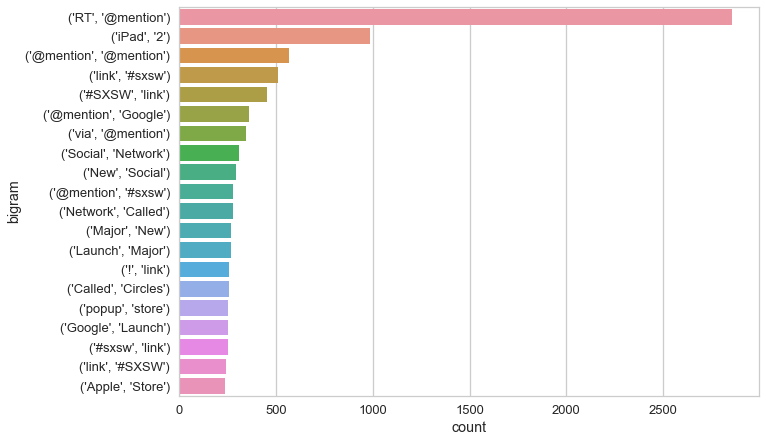

In [89]:
sns.barplot(data=bigram_df, x="count", y="bigram")

## Network plot of bigrams

In [90]:
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

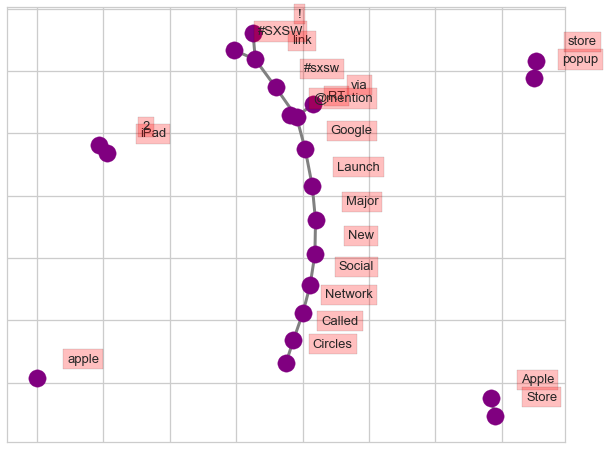

In [91]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

G.add_node("apple", weight=100)

fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=12,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.175, value[1]+.050
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)

plt.show()

# TBD: LDA visualization

# Modeling

## TBD: Multiple classifiers, tuning, better display of metrics, feature impact/analysis of models

In [92]:
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.ensemble import RandomForestClassifier

## DataFrameMapper with Tf-idf Vectorization

In [93]:
mapper = DataFrameMapper([
     ('text', TfidfVectorizer()),
     ('direction', None),
     ('tweet_words', None),
    ('hash_cnt', None),
    ('mention_cnt', None),
    ('capital_words', None),
    ('excl_q_marks', None)
 ])

In [94]:
X = mapper.fit_transform(clean_df)

In [95]:
X

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 2., 1., 1.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [96]:
clean_df.direction.value_counts(dropna=False)

2    5801
0    2409
1     882
Name: direction, dtype: int64

## Creation of dataframe with only positive and negative sentiment

In [97]:
df_posneg = clean_df.copy()
df_posneg = df_posneg[df_posneg.direction !=2]

df_posneg.direction.value_counts(dropna=False)

0    2409
1     882
Name: direction, dtype: int64

In [98]:
mapped_pn = mapper.fit_transform(df_posneg)
mapped_pn

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 2., 1., 1.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [99]:
X_posneg = mapped_pn
y_posneg = df_posneg['sentiment']

## Train test splits

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
y = clean_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)

## Train test split for positive and negative only

In [101]:
X_train_posneg, X_test_posneg, y_train_posneg, y_test_posneg = train_test_split(X_posneg, y_posneg, test_size=0.33, random_state=42,stratify=y_posneg)

## PCA train_test split- TBD if/how using

In [102]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = X
pca.fit(X_pca)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.33, random_state=42,stratify=y)

## Comparing class balance between full dataset and dataset without NaN products

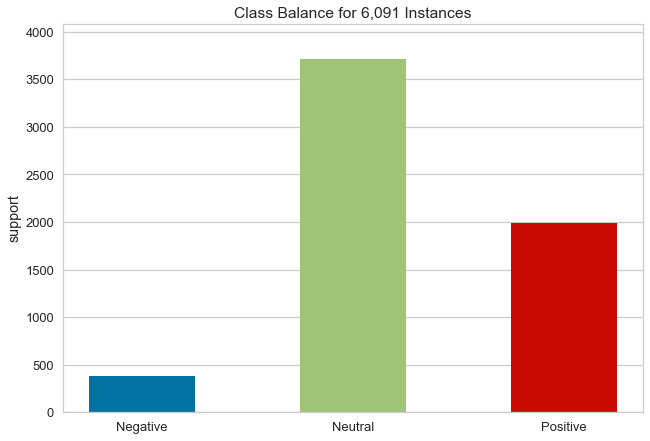

In [103]:
from yellowbrick.target import ClassBalance
visualizer = ClassBalance(labels=["Negative", "Neutral", "Positive"])

visualizer.fit(y_train)        # Fit the data to the visualizer
visualizer.show()

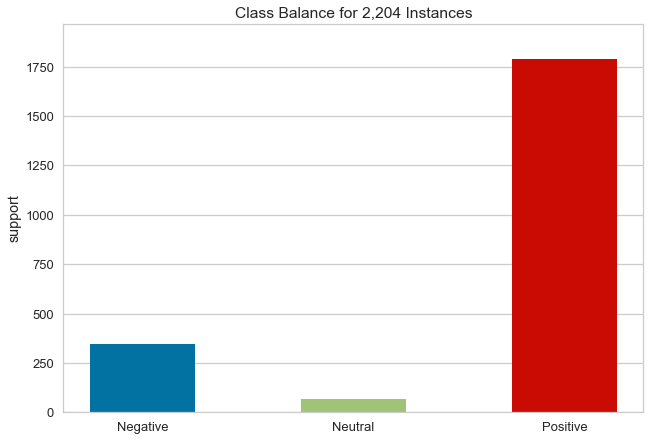

In [104]:
from yellowbrick.target import ClassBalance
visualizer = ClassBalance(labels=["Negative", "Neutral", "Positive"])

visualizer.fit(y_train_posneg)        # Fit the data to the visualizer
visualizer.show()

# Multinomial NB Base Model for Comparison

In [105]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [106]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       188
           1       0.70      1.00      0.82      1830
           2       0.85      0.33      0.47       983

    accuracy                           0.72      3001
   macro avg       0.51      0.44      0.43      3001
weighted avg       0.70      0.72      0.65      3001



In [107]:
from sklearn.metrics import hamming_loss
print(hamming_loss(y_test, y_pred))

0.28490503165611464


In [108]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_test, y_pred))

0.33141249047287125


In [109]:
from sklearn.metrics import fbeta_score

def fscores(y_test=y_test, y_pred=y_pred):
    f05 = fbeta_score(y_test, y_pred, average=None, beta=0.5, labels=[0,1,2])
    f2 = fbeta_score(y_test, y_pred, average=None, beta=2.0, labels=[0,1,2])
    for idx,c in enumerate(f05):
        print (f'F0.5 of {idx} class is {f05[idx]}')
        print (f'F2 of {idx} class is {f2[idx]}')
        print ('-----------')

fscores()

F0.5 of 0 class is 0.0
F2 of 0 class is 0.0
-----------
F0.5 of 1 class is 0.7402892897773444
F2 of 1 class is 0.9165912063587887
-----------
F0.5 of 2 class is 0.6451612903225806
F2 of 2 class is 0.37552155771905427
-----------


## Modeling without no product tweets

In [110]:
model = MultinomialNB()
model.fit(X_train_posneg, y_train_posneg)
y_pred_posneg = model.predict(X_test_posneg)

In [111]:
print(metrics.classification_report(y_test_posneg,y_pred_posneg))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       171
           1       0.00      0.00      0.00        33
           2       0.81      1.00      0.90       883

    accuracy                           0.81      1087
   macro avg       0.27      0.33      0.30      1087
weighted avg       0.66      0.81      0.73      1087



In [112]:
from sklearn.metrics import hamming_loss
print(hamming_loss(y_test_posneg, y_pred_posneg))

0.18767249310027598


In [113]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_test_posneg, y_pred_posneg))

0.0


In [114]:
fscores(y_test_posneg, y_pred_posneg)

F0.5 of 0 class is 0.0
F2 of 0 class is 0.0
-----------
F0.5 of 1 class is 0.0
F2 of 1 class is 0.0
-----------
F0.5 of 2 class is 0.8440068820493213
F2 of 2 class is 0.9558345962329508
-----------


# SMOTE on full dataset

In [115]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)
print (y_train.value_counts() , np.bincount(y_train_res))

1    3714
2    1995
0     382
Name: sentiment, dtype: int64 [3714 3714 3714]


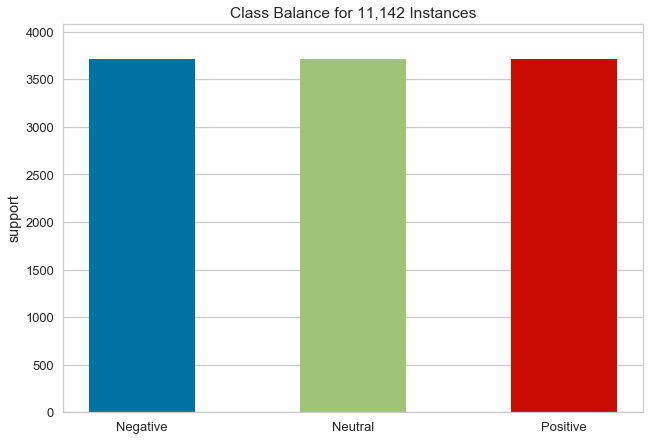

In [116]:
from yellowbrick.target import ClassBalance
visualizer = ClassBalance(labels=["Negative", "Neutral", "Positive"])

visualizer.fit(y_train_res)        # Fit the data to the visualizer
visualizer.show()

## Multinomial NB on SMOTE

In [117]:
sm_model = MultinomialNB()
sm_model.fit(x_train_res, y_train_res)
y_pred_smote = sm_model.predict(X_test)
print(metrics.classification_report(y_test,y_pred_smote))

              precision    recall  f1-score   support

           0       0.44      0.56      0.49       188
           1       0.87      0.96      0.91      1830
           2       0.90      0.69      0.78       983

    accuracy                           0.85      3001
   macro avg       0.74      0.73      0.73      3001
weighted avg       0.85      0.85      0.84      3001



In [118]:
print(hamming_loss(y_test, y_pred_smote))

0.15494835054981673


In [119]:
print(cohen_kappa_score(y_test, y_pred_smote))

0.6926470656254067


In [120]:
fscores(y_test, y_pred_smote)

F0.5 of 0 class is 0.4621478873239436
F2 of 0 class is 0.5308392315470172
-----------
F0.5 of 1 class is 0.8893500708645475
F2 of 1 class is 0.9413844834976425
-----------
F0.5 of 2 class is 0.8443998997744927
F2 of 2 class is 0.7194705380017079
-----------


# SMOTE on data w/o NaN products

In [121]:
sm = SMOTE(random_state=12)
x_train_pn_res, y_train_pn_res = sm.fit_sample(X_train_posneg, y_train_posneg)
print (y_train_posneg.value_counts() , np.bincount(y_train_pn_res))

2    1789
0     348
1      67
Name: sentiment, dtype: int64 [1789 1789 1789]


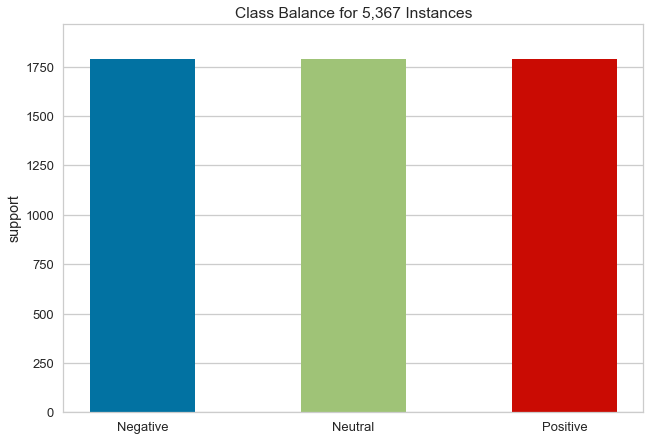

In [122]:
from yellowbrick.target import ClassBalance
visualizer = ClassBalance(labels=["Negative", "Neutral", "Positive"])

visualizer.fit(y_train_pn_res)        # Fit the data to the visualizer
visualizer.show()

In [123]:
sm_pn_model = MultinomialNB()
sm_pn_model.fit(x_train_pn_res, y_train_pn_res)
y_pred_pn_smote = sm_pn_model.predict(X_test_posneg)
print(metrics.classification_report(y_test_posneg,y_pred_pn_smote))

              precision    recall  f1-score   support

           0       0.48      0.58      0.53       171
           1       0.07      0.15      0.09        33
           2       0.91      0.83      0.87       883

    accuracy                           0.77      1087
   macro avg       0.48      0.52      0.49      1087
weighted avg       0.82      0.77      0.79      1087



In [124]:
print(hamming_loss(y_test_posneg, y_pred_pn_smote))

0.23183072677092917


In [125]:
print(cohen_kappa_score(y_test_posneg, y_pred_pn_smote))

0.3692834084723674


In [126]:
fscores(y_test_posneg, y_pred_pn_smote)

F0.5 of 0 class is 0.496524329692155
F2 of 0 class is 0.5599104143337066
-----------
F0.5 of 1 class is 0.07507507507507508
F2 of 1 class is 0.12077294685990338
-----------
F0.5 of 2 class is 0.8913308913308914
F2 of 2 class is 0.8419838523644751
-----------


# Dataset/SMOTE Conclusion: Using just negative/positive sentiment loses predictive power on the neutral class

# TBD: Other sampling methods

## ADASYN on total dataset - minor effects

In [127]:
from imblearn.over_sampling import ADASYN # doctest: +NORMALIZE_WHITESPACE
print('Original dataset shape %s' % Counter(y_train))
ada = ADASYN(random_state=42)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_ada))

Original dataset shape Counter({1: 3714, 2: 1995, 0: 382})
Resampled dataset shape Counter({2: 3979, 1: 3714, 0: 3596})


In [129]:
sm_model = MultinomialNB()
sm_model.fit(X_train_ada, y_train_ada)
y_pred_ada = sm_model.predict(X_test)
print(metrics.classification_report(y_test,y_pred_ada))

              precision    recall  f1-score   support

           0       0.44      0.54      0.49       188
           1       0.90      0.91      0.90      1830
           2       0.80      0.76      0.78       983

    accuracy                           0.84      3001
   macro avg       0.72      0.74      0.72      3001
weighted avg       0.84      0.84      0.84      3001



## SMOTENN on total dataset

In [130]:
from imblearn.combine import SMOTEENN
print('Original dataset shape %s' % Counter(y_train))
smoteenn = SMOTEENN(random_state=42)
X_train_sme, y_train_sme = smoteenn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_sme))

Original dataset shape Counter({1: 3714, 2: 1995, 0: 382})
Resampled dataset shape Counter({0: 3700, 2: 2689, 1: 2273})


In [131]:
sm_model = MultinomialNB()
sm_model.fit(X_train_sme, y_train_sme)
y_pred_sme = sm_model.predict(X_test)
print(metrics.classification_report(y_test,y_pred_sme))

              precision    recall  f1-score   support

           0       0.24      0.73      0.36       188
           1       0.90      0.89      0.89      1830
           2       0.88      0.56      0.68       983

    accuracy                           0.77      3001
   macro avg       0.67      0.73      0.65      3001
weighted avg       0.85      0.77      0.79      3001



## Gaussian NB

In [139]:
from sklearn.naive_bayes import GaussianNB
sm_model = GaussianNB()
sm_model.fit(x_train_res, y_train_res)
y_pred_smote = sm_model.predict(X_test)
print(metrics.classification_report(y_test,y_pred_smote))

              precision    recall  f1-score   support

           0       0.14      0.33      0.20       188
           1       0.71      0.44      0.54      1830
           2       0.43      0.64      0.52       983

    accuracy                           0.50      3001
   macro avg       0.43      0.47      0.42      3001
weighted avg       0.59      0.50      0.51      3001



## Random Forest Classifier

In [140]:
from sklearn.ensemble import RandomForestClassifier
sm_model = RandomForestClassifier()
sm_model.fit(x_train_res, y_train_res)
y_pred_smote = sm_model.predict(X_test)
print(metrics.classification_report(y_test,y_pred_smote))

              precision    recall  f1-score   support

           0       0.68      0.19      0.30       188
           1       0.93      0.97      0.95      1830
           2       0.83      0.88      0.86       983

    accuracy                           0.89      3001
   macro avg       0.82      0.68      0.70      3001
weighted avg       0.88      0.89      0.88      3001



# TBD: Conclusions - best model results and interpretation, business recommendations, future work

# Future work: Outlier detection approaches, multilabel classification